<a href="https://colab.research.google.com/github/Luke-687/Portfolio/blob/main/FirstChemoTaxisAttempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [378]:
import matplotlib.pyplot as plt
import random
import math

#Thinking of states as bad-->bad, bad-->good, good-->bad, good-->good in which past actions will help inform future actions
#Say we move from good-->good, then the action which brought us to do so will be favored once more.
#split into 3 possible actions, in which the entity can move in 120 degree sections of a full circle, moving 1-3 steps at a time

#States good and bad refer to perceived position based on chemicals
states = ["good", "bad"]

actions = {
    "good": [1,2],
    "bad":[1,2]
}

rGood = 15
rBad = -10

pGoodGood1 = 0.50
pGoodBad1 = 0.50

pGoodGood2 = 0.50
pGoodBad2 = 0.50

pBadGood1 = 0.50
pBadBad1 = 0.50

pBadGood2 = 0.50
pBadBad2 = 0.50

transitions = {
    ("good",1): [("good",pGoodGood1,rGood), ("bad",pGoodBad1,rBad)],
    ("good",2): [("good",pGoodGood2,rGood),("bad",pGoodBad2,rBad)],
    ("bad",1): [("good",pBadGood1,rGood),("bad",pBadBad1,rBad)],
    ("bad",2): [("good",pBadGood2,rGood),("bad",pBadBad2,rBad)],
}

In [379]:
def calcReward(color):
  if(color == "green"):
    return rGood*1
  elif(color == "yellow"):
    return rGood*0.5
  else:
    return -10

def gradients():
  #center of good chemical is (10,10)
  XYColor = []
  gradient = []
  x = []
  y= []
  currentColor = "white"
  for i in range (0,20):
    for j in range(0,20):
      if(math.sqrt((i-10)**2+(j-10)**2)<4):
        currentColor = "yellow"
      if(math.sqrt((i-10)**2+(j-10)**2)<2):
        currentColor = "green"
      if(math.sqrt((i-10)**2+(j-10)**2)>=4):
        currentColor = "white"
      XYColor.append([j,i,currentColor])
  for i in range(0, len(XYColor)):
    gradient.append(XYColor[i][2])
    x.append(XYColor[i][0])
    y.append(XYColor[i][1])

  return x, y, gradient

#define environmet
xGradient, yGradient, colors = gradients()

In [380]:
#Idea: given a state starting at 0,0, read the gradients from the graph of points, doing so essentially based on 4 different colors split up by proximity to target
#After reading the gradient, decide if it's good or bad, assume you begin at a bad state essential every time.
#Start with a random action from 0,0, and evalute the position it brings you to from there, use the gradient of this position to determine if you went from b->g, or whatever it is
#Knowing you went from one state to another, evaluate the probability for that state, increase probability of something good coming out of that movement
#Meaning say you started at bad and moved to good using move 1, then increase the probability of bad using move 1 will lead to something good, say increase by 0.1 and decear bad using move 1 leads to bad by -0.1

#Run bellman equation for each new step, but first to set up initial values

#Initial policy:
V = {s: 0 for s in states}
policy = {s: None for s in states}


for s in states:
    actVals = {}
    for a in actions[s]:
      tot = 0
      for (s_next, prob, reward) in transitions[(s, a)]:
        tot += prob * (reward + 0.9 * V[s_next])
      actVals[a] = tot
    maxAct = max(actVals, key = actVals.get)
    V[s] = actVals[maxAct]
    policy[s] = maxAct

#How many steps?
steps = 50

currentX = 0
currentY = 0
x = [0]
y = [0]

#Loop through for n number of steps!
for i in range(0, steps):
  # Ensure currentX and currentY stay within bounds
  currentX = max(0, min(currentX, 19))
  currentY = max(0, min(currentY, 19))

  currentState = colors[(currentX+currentY*20)]
  if(calcReward(currentState)>0):
    currentState = "good"
  else:
    currentState = "bad"

  #Refine the policy based on current state
  actVals = {} # Initialize actVals here
  for a in actions[currentState]:
    tot = 0
    for(s_next, prob, reward) in transitions[(currentState, a)]:
      tot += prob * (reward + 0.9 * V[s_next])
    actVals[a] = tot

  # Check if actVals is empty before finding maxAct
  if actVals:
      maxAct = max(actVals, key = actVals.get)
      V[currentState] = actVals[maxAct]
      policy[currentState] = maxAct
  else:
      # Handle the case where actVals is empty, perhaps by choosing a default action
      maxAct = random.choice(actions[currentState]) # Example: choose a random action
      policy[currentState] = maxAct


  move = policy[currentState]
  if(move == 1):
    currentX+= random.randint(-1,1)
    currentY+= random.randint(1,2)
  elif(move == 2):
    currentX+= random.randint(-1,1)
    currentY+= random.randint(-2,-1)

  x.append(currentX)
  y.append(currentY)

  # Ensure currentX and currentY stay within bounds after movement
  currentX = max(0, min(currentX, 19))
  currentY = max(0, min(currentY, 19))

  newState = colors[(currentX+currentY*20)]
  if(calcReward(newState)>0):
    newState = "good"
  else:
    newState = "bad"


  #change in prob vv
  c = 0.5

  #redifine transitionProbs:
  if(move ==1):
    if(currentState == "good"):
      if(newState =="good"):
        pGoodGood1 +=c
        pGoodBad1-=c
        if(pGoodBad1<0):
          pGoodBad1=0
      else:
        pGoodGood1 -=c
        pGoodBad1+=c
        if(pGoodGood1<0):
          pGoodGood1=0
    else:
      if(newState == "good"):
        pBadGood1 +=c
        pBadBad1-=c
        if(pBadBad1<0):
          pBadBad1 =0
      else:
        pBadBad1+=c
        pBadGood1-=c
        if(pBadGood1<0):
          pBadGood1=0
  else:
    if(currentState == "good"):
      if(newState =="good"):
        pGoodGood2 +=c
        pGoodBad2-=c
        if(pGoodBad2<0):
          pGoodBad2=0
      else:
        pGoodGood2 -=c
        pGoodBad2+=c
        if(pGoodGood2<0):
          pGoodGood2=0
    else:
      if(newState == "good"):
        pBadGood2 +=c
        pBadBad2-=c
        if(pBadBad2<0):
          pBadBad2 =0
      else:
        pBadBad2+=c
        pBadGood2-=c
        if(pBadGood2<0):
          pBadGood2=0

  # Update the transitions dictionary with the new probabilities
  transitions[("good", 1)] = [("good", pGoodGood1, rGood), ("bad", pGoodBad1, rBad)]
  transitions[("good", 2)] = [("good", pGoodGood2, rGood), ("bad", pGoodBad2, rBad)]
  transitions[("bad", 1)] = [("good", pBadGood1, rGood), ("bad", pBadBad1, rBad)]
  transitions[("bad", 2)] = [("good", pBadGood2, rGood), ("bad", pBadBad2, rBad)]

[0, 0, -1, 1, 0, 1, 2, 2, 2, 2, 3, 2, 3, 4, 5, 4, 3, 3, 3, 4, 5, 6, 6, 7, 6, 7, 6, 7, 8, 7, 8, 8, 9, 8, 9, 9, 9, 10, 11, 10, 10, 10, 10, 10, 11, 10, 9, 8, 7, 8, 7]
[0, 1, -1, 1, -1, 1, 0, 1, -1, 2, 1, 2, 0, 2, 1, 2, 0, 1, 0, 1, -1, 2, 1, 2, 1, 3, 2, 3, 2, 4, 3, 4, 3, 5, 4, 6, 4, 5, 4, 5, 4, 5, 3, 4, 3, 4, 2, 4, 2, 4, 2]


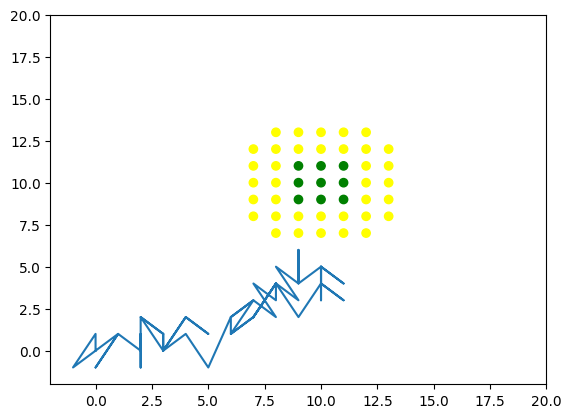

In [381]:
#Visualize using x pos, y pos, and the initial blob of positive particles
print(x)
print(y)
plt.scatter(xGradient, yGradient, color = colors)
plt.plot(x,y)